# Example figure, just as a demonstration
# Coded by me: Hossain Shadman 

# Explanation of below figure:
* Combine the gene expression of integrin ITGA7 with another gene set relevant to breast cancer
* Implement random forest model using these genes as features 
* Run model 500 times (each time with random 50:50 train-test split)
* Get feature importance from those 500 iterations
* Plot feature importance mean + standard deviation (plot below)
* integrin outperforms another functional gene set.
* The breast cancer gene set is from this paper: https://www.sciencedirect.com/science/article/pii/S2211124720310949

CPU times: user 36min 41s, sys: 10.8 s, total: 36min 51s
Wall time: 36min 57s


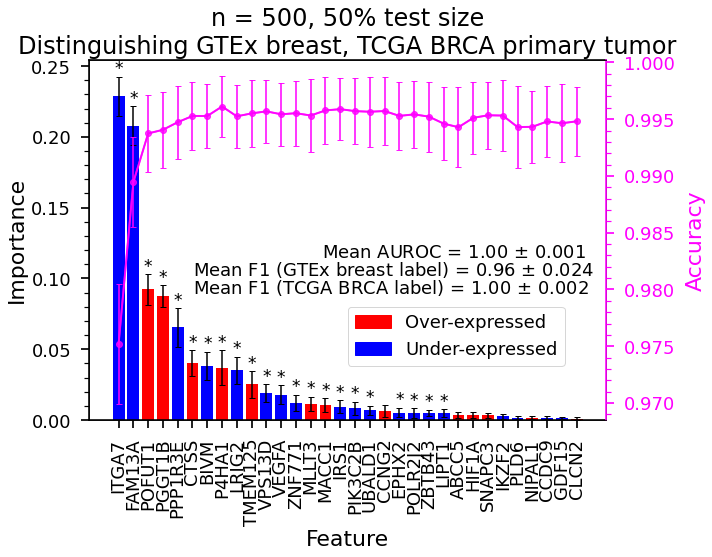

In [153]:
%%time
label_canc='Distinguishing GTEx breast, TCGA BRCA primary tumor'
#class weight balanced here
#DO NOT MAKE mistake on title cancer label. be careful 
fig, ax = plt.subplots(2,1, figsize=(10, 13))
n=500
feature_importance=[]
accuracy=[]
test_size=0.50
auc_roc=[]
f1score_normal=[]
f1score_primtum=[]
y_test_total=[]
y_pred_total=[]
cum_acc_mean=[]
cum_acc_std=[]
cum_acc_itg=[]
feature_importances={"feature": [],"importance": []}
#first calculate the feature importance and accuracy etc.
for iteration in range(n):
    X = combined_donato32[combined_donato32.columns[combined_donato32.columns!='sample_category']]
    y = combined_donato32.sample_category
    #scaler = StandardScaler()
    #X_scaled = scaler.fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size) 
    ### Random Forest Classifier ###
    classifier = RandomForestClassifier(n_estimators=100, random_state=42,
                                        class_weight= 'balanced')
    classifier.fit(X_train,y_train)
    y_pred = classifier.predict(X_test)
    y_test_total=y_test_total+list(y_test)
    y_pred_total=y_pred_total+list(y_pred)
    accuracy.append(accuracy_score(y_test,y_pred))
    f1score_normal.append(f1_score(y_test,y_pred,pos_label = 'normal_breast'))
    f1score_primtum.append(f1_score(y_test,y_pred,pos_label = 'BRCA_primtum'))    
    auc_roc.append(roc_auc_score(y_test,classifier.predict_proba(X_test)[:,1]))
    for i,j in zip(X.columns,classifier.feature_importances_):
        feature_importances['feature'].append(i) 
        feature_importances['importance'].append(j)

        


        
#now plotting
pd.DataFrame(accuracy,columns=['accuracy']).plot(kind='hist',edgecolor='black',ax=ax[0],legend=False)
# ax[0].set_title(f"n= {n}",fontsize=25)
# #ax[0].legend(fontsize=13)
# plt.setp(ax[0].get_xticklabels(),fontsize=12)
# plt.setp(ax[0].get_yticklabels(),fontsize=12)
# ax[0].set_ylabel('Frequency',fontsize=25)
feature_importance_df=pd.DataFrame(feature_importances).set_index('feature')
feature_importance_df = feature_importance_df.sort_values(by='importance')
# for i in ['top', 'left', 'right', 'bottom']:
#     ax[0].spines[i].set_linewidth(1.6)

# ax[0].minorticks_on()
# ax[0].tick_params(axis='both', which='major', labelsize=12, width = 1.7, size = 8,pad=10)
# ax[0].tick_params(axis='both', which='minor', width = 1.2, size = 5)   
# ax[0].set_xlabel('Accuracy',fontsize=25)


#feature_importance_df_mean=feature_importance_df.groupby('feature').mean().sort_values(by='importance',ascending=False)

#feature_importance_df_err=feature_importance_df.groupby('feature').std().loc[feature_importance_df_mean.index]

feature_importance_df_mean=feature_importance_df.groupby('feature').mean().sort_values(by='importance',ascending=False)
feature_importance_df_mean=pd.concat([feature_importance_df_mean,itg_expr_df],axis=1)
feature_importance_df_err=feature_importance_df.groupby('feature').std().loc[feature_importance_df_mean.index]
colors = feature_importance_df_mean.groupby('relative_expression')['bar_color'].apply(lambda x: list(x.unique())[0]).to_dict()

#now calculate cumulatve feature vs accuracy
for cum_gene in range(1,feature_importance_df_mean.shape[0]+1):
    cum_individual_accuracy = []
    for iteration in range(n):
        X = combined_donato32[feature_importance_df_mean.index[0:cum_gene]]
        y = combined_donato32.sample_category
        #scaler = StandardScaler()
        #X_scaled = scaler.fit_transform(X)

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size) 
        ### Random Forest Classifier ###
        classifier = RandomForestClassifier(n_estimators=100, random_state=42,
                                            class_weight= 'balanced')
        classifier.fit(X_train,y_train)
        y_pred = classifier.predict(X_test)
        cum_individual_accuracy.append(accuracy_score(y_test,y_pred))
    cum_acc_itg.append(combined_donato32[feature_importance_df_mean.index[cum_gene-1]].name)
    cum_acc_mean.append(np.mean(np.array(cum_individual_accuracy)))
    cum_acc_std.append(np.std(np.array(cum_individual_accuracy)))


#first plot the barplot
bars=ax[1].bar(feature_importance_df_mean.index,
    feature_importance_df_mean['importance'],
                                yerr=feature_importance_df_err['importance'].values,
                                capsize=3,
                                    color=feature_importance_df_mean.bar_color)
for bar,integrin in zip(bars.patches,feature_importance_df_mean.index):
    if feature_importance_df_mean.loc[integrin]['adj_significant_bonf']=='yes':
        ax[1].annotate('*',
                   (bar.get_x() + bar.get_width()/2,
                    bar.get_height()+feature_importance_df_err.loc[integrin]['importance']), ha='center', va='center',
                   size=17, xytext=(0, 8),
                   textcoords='offset points')

ax2 = ax[1].twinx()
#plot the cum accuracy feature
ax2.errorbar(cum_acc_itg, cum_acc_mean,
            yerr=cum_acc_std,capsize=3,color='fuchsia', alpha=0.9, lw=1.7)
ax2.plot(cum_acc_itg, cum_acc_mean, '-o',markersize=6,
         color='fuchsia', lw=2, alpha=0.8)
ax2.set_ylabel('Accuracy', fontsize=22,labelpad=10, color='fuchsia')


ax[1].set_title(f"n = {n}, {int(test_size*100)}% test size\n{label_canc}",fontsize=24)
plt.setp(ax[1].get_xticklabels(),fontsize=18,rotation=90)
plt.setp(ax2.get_yticklabels(),fontsize=18)
ax[1].set_xlabel('Feature',fontsize=22)
ax[1].set_ylabel('Importance',fontsize=22,color='black')
#ax[1].legend(feature_importance_df_mean.relative_expression.unique(),fontsize=17)
handles = [mpatches.Patch(color=colors[i]) for i in colors]
labels = ['Over-expressed' if i=='high' else 'Under-expressed' for i in colors ]
ax[1].legend(handles, labels,fontsize=18,loc=(0.5,0.15))

for i in ['top', 'left', 'bottom']:
    ax[1].spines[i].set_linewidth(1.6)

ax2.spines['right'].set_color('fuchsia')    
ax2.spines['right'].set_linewidth(1.6)    
    
ax[1].minorticks_on()
ax[1].tick_params(axis='both', which='major', labelsize=18, width = 1.7, size = 8,pad=10)
ax[1].tick_params(axis='y', which='minor', width = 1.2, size = 5)    

ax2.minorticks_on()
ax2.tick_params(axis='both', which='major', labelsize=18, width = 1.7, size = 8,pad=10,colors='fuchsia')
ax2.tick_params(axis='y', which='minor', width = 1.2, size = 5,colors='fuchsia')    
ax2.xaxis.set_minor_locator(tck.NullLocator())
# ax[1].text(0.45,
#            0.5,
# f'Mean Accuracy = {format(np.mean(np.array(accuracy)),"0.2f")} $\pm$ {format(np.std(np.array(accuracy)),"0.4f")}',
#            transform=ax[1].transAxes,fontsize=18)
# ax[1].text(0.3,
#            0.52,
# 'With all features combined:',
#            transform=ax[1].transAxes,fontsize=18)
ax[1].text(0.45,
           0.45,
f'Mean AUROC = {format(np.mean(np.array(auc_roc)),"0.2f")} $\pm$ {format(np.std(np.array(auc_roc)),"0.3f")}',
           transform=ax[1].transAxes,fontsize=18)
ax[1].text(0.2,
           0.4,
f'Mean F1 (GTEx breast label) = {format(np.mean(np.array(f1score_normal)),"0.2f")} $\pm$ {format(np.std(np.array(f1score_normal)),"0.3f")}',
           transform=ax[1].transAxes,fontsize=18)
ax[1].text(0.2,
           0.35,
f'Mean F1 (TCGA BRCA label) = {format(np.mean(np.array(f1score_primtum)),"0.2f")} $\pm$ {format(np.std(np.array(f1score_primtum)),"0.3f")}',
           transform=ax[1].transAxes,fontsize=18)

ax[0].remove()
plt.tight_layout()

plt.savefig(f'figures/RF_donato_ITGA7_class-weight_bal.png', dpi = 1000, bbox_inches='tight')
del itg_expr_df, feature_importance, feature_importance_df, feature_importance_df_mean, feature_importance_df_err

